# CAB420 Assignment 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

def r_squared(actual, predicted):
    r2 = r2_score(actual, predicted)
    return r2

def adj_r2(actual, predicted, n, p):
    r2 = r2_score(actual, predicted)
    adjr2 = 1 - (1 - r2) * (n - 1) / (n - p - 1);
    return adjr2

def standardise(data):
    """ 
    Standardise/Normalise data to have zero mean and unit variance

      Args:
        data (np.array):
          data we want to standardise (usually covariates)

        Returns:
          Standardised data, mean of data, standard deviation of data
    """
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    scaled = (data - mu) / sigma
    return scaled, mu, sigma

def evaluate_regularisation(x_train, y_train, x_val, y_val, x_test, y_test,
                            response_mu, response_sigma, alpha_list, L1_L2):
    """
  Evaluates the efficacy of regularisation for a linear model.
  
  Identifies which values regression coffections and values of alpha
  (the hyperparam for the strength of regularisation) offers the
  best performance on the validation set.

  Evaluation is required to be performed on the standardised data, to allow
  for ease of comparison (where standardised here refers to normalisation,
  such that the data has a mean of zero and a std. of one.) This will show
  
  Will display the coefficients used in the NORMALISED/STANDARDISED model 
  used to achieve the best results.

  Is able to evaluate both Ridge and Lasso regularisation (and Elasticnet
  really if you want to try it, but in this class we are sticking to Ridge
  and Lasso).

  Args:
    x_train (np.array):
      normalised predictor variable training data
    y_train (np.array):
      normalised response variable training data
    x_val (np.array):
      normalised predictor variable validation data
    y_val (np.array):
      normalised response variable validation data
    x_test (np.array):
      normalised predictor variable test data
    y_test (np.array):
      normalised response variable test data
    response_mu (np.array):
      the mean value of the response variable from the TRAINING data
    response_sigma (np.array):
      the standard deviation  of the response variable from the TRAINING data
    alpha_list (list[np.float]):
      proposed values for alpha (the regularisation hyper param, also called
      lambda in other texts and in the lectures). Each value must be greater
      than zero.
    L1_L2 (np.int):
      Boolean to say whether we want to perform Ridge or Lasso regularisation.
      When zero, will be Ridge, When one, will be Lasso.
      Note: this value can actually be a float between zero and one as well 
      if you want to try Elasticnet regression, but here in this class would
      recommend sticking to just Ridge and Lasso.

  Retuns:
    NA
  """
  # Ridge: L1_L2 = 0
  # Lasso: L1_L2 = 1
  # create the model
    model = sm.OLS(y_train, x_train)
  # initialise the value for best RMSE that is obnoxiously large, as we want this be 
  # overwritten each time RMSE is smaller, since smaller is better and we want to 
  # update our best models each time the RMSE is smaller.
    best_rmse = 10e12
    best_alpha = []
    best_coeffs = []
  
    rmse_val = []
    rmse_train = []
    coeffs = []          # only needed for trace plots

    for alpha in alpha_list:
        model_cross_fit = model.fit_regularized(alpha=alpha, L1_wt=L1_L2)
        train_pred = (model_cross_fit.predict(x_train))
        val_pred = (model_cross_fit.predict(x_val))
    # want to append the rmse value to a list, as will plot all values later on
        rmse_train.append(rmse((y_train), train_pred))
        rmse_val.append(rmse((y_val), val_pred))
        coeffs.append(model_cross_fit.params)
    # if this is the model with the lowest RMSE, lets save it
    # the [-1] index says get the last value from the list (which is the most recent RMSE)
        if rmse_val[-1] < best_rmse:
            best_rmse = rmse_val[-1]
            best_alpha = alpha
            best_coeffs = model_cross_fit.params
      
    print('Best values on Validation Data set')
  # extract the gradient and the bias from the coefficients
  # The reshape will make sure the slope is a column vector
    slope = np.array(best_coeffs[0:]).reshape(-1, 1)
  # the intercept coefficient is the last index variable, which was included with the
  # sm.add_constant() method
  # use the @ operator to perform vector/matrix multiplication
    pred_val_rescaled = ((x_val @ slope) * response_sigma + response_mu) 
    pred_test_rescaled = ((x_test @ slope)* response_sigma + response_mu)
    pred_train_rescaled = ((x_train @ slope)* response_sigma + response_mu)
    best_r2 = r_squared(((y_train)* response_sigma + response_mu), pred_train_rescaled)
    best_adj_r2 = adj_r2(((y_train)* response_sigma + response_mu), pred_train_rescaled,
                           x_train.shape[0], x_train.shape[1]) 
    best_train_rmse = rmse(((y_train)* response_sigma + response_mu),pred_train_rescaled)
    best_val_rmse = rmse(((y_val)* response_sigma + response_mu), pred_val_rescaled)
    best_test_rmse = rmse(((y_test)* response_sigma + response_mu), pred_test_rescaled)
    print('Best R Squared = {}'.format(best_r2))
    print('Best Adjusted = {}'.format(best_adj_r2))
    print('Best RMSE (train) = {}'.format(best_train_rmse))
    print('Best RMSE (val) = {}'.format(best_val_rmse))
    print('Best RMSE (test) = {}'.format(best_test_rmse))
    print('Best Alpha = {}'.format(best_alpha))
    print('Best coefficients on the normalised model')
    print('Best slope = {}'.format(slope))
    
  # now plotting some data
    fig, axs = plt.subplots(5, figsize=(15, 25))
  
  # plot the first values of alpha vs RMSE for train and validation data    
    axs[0].plot(np.array(alpha_list), rmse_train)
    axs[0].plot(np.array(alpha_list), rmse_val)
    axs[0].legend(['Training', 'Validation'])
    axs[0].set_title('RMSE vs Lambda')
    axs[0].set_xlabel('Lambda')
    axs[0].set_ylabel('RMSE')    
  
  # plot prediction and true values for test set
    axs[1].plot((y_test*response_sigma + response_mu))
    axs[1].plot((x_test @ slope) * response_sigma + response_mu)
    axs[1].legend(['Actual', 'Predicted'])
    axs[1].set_title('Test Set Performance')
  
  # plotting the Q-Q plot
    train_pred = (x_train @ slope).reshape(y_train.shape)
    resid = y_train - train_pred
    sm.qqplot(resid, ax=axs[2], line='s')
    axs[2].set_title('Q-Q Plot for Linear Regression')

  # plot the residuals as well
    axs[3].scatter(train_pred, resid)
    axs[3].set_title('Residuals for training set')
    axs[3].set_xlabel('Predicted')
    axs[3].set_ylabel('Residuals')

  # trace plot of coefficients
    axs[4].plot(np.array(alpha_list), coeffs)
    axs[4].set_title('Trace PLot of Coefficients')
    axs[4].set_xlabel('Lambda')
    axs[4].set_ylabel('Coefficient Value')
  
    model_cross_fit = model.fit_regularized(alpha=best_alpha, L1_wt=L1_L2)
    Y_train_pred = model_cross_fit.predict(x_train)
    Y_test_pred = model_cross_fit.predict(x_test)
    rmse_train = np.sqrt(np.mean(((Y_train_pred*sigma_train_y + mu_train_y) - (y_train*sigma_train_y + mu_train_y))**2))
    rmse_test = np.sqrt(np.mean(((Y_test_pred*sigma_train_y + mu_train_y) - (y_test*sigma_train_y + mu_train_y))**2))

    fig = plt.figure(figsize=[20, 8])
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(np.arange(len(Y_train_pred)), Y_train_pred*sigma_train_y + mu_train_y, label='Predicted')
    ax.plot(np.arange(len(Y_train_pred)), y_train*sigma_train_y + mu_train_y, label='Actual')
    ax.set_title(rmse_train)
    ax.legend()
    ax = fig.add_subplot(2, 1, 2)
    ax.plot(np.arange(len(Y_test_pred)), Y_test_pred*sigma_train_y + mu_train_y, label='Predicted')
    ax.plot(np.arange(len(Y_test_pred)), y_test*sigma_train_y + mu_train_y, label='Actual')
    ax.set_title(rmse_test)
    ax.legend();
    return model_cross_fit, rmse_test, rmse_train

In [3]:
data = pd.read_csv('shipping_data.csv')
data.head()

,weight (kg),length (m),width (m),height (m),name,shipment date,destination port,price ($)
0,1.10,0.40,0.39,0.26,Camera Bag,19/03/2023,Port of Singapore (Singapore),37.66
1,0.39,0.11,0.06,0.03,Portable Bluetooth Keyboard,21/03/2023,Port of Busan (South Korea),144.65
2,0.97,0.79,0.55,0.35,Large Flat Rate Box,25/03/2023,Port of Tianjin (China),38.57
3,6.22,0.36,0.37,0.02,Ceramic Tiles,15/03/2023,Port of Shanghai (China),10.34
4,1.18,17.77,0.27,0.13,Garden Hose,25/03/2023,Port of Tianjin (China),21.63


In [4]:
print(np.shape(data))
clean_data = data.dropna()
print(np.shape(clean_data))

(263821, 8)
(260961, 8)


In [5]:
data =  clean_data
data = data.loc[data['destination port'] == 'Port of Tokyo (Japan)']
print(np.shape(data))

(52263, 8)


In [6]:
label_encoder = LabelEncoder()
data_copy = data.copy()
data_copy['name_encoded'] = label_encoder.fit_transform(data_copy['name'])

# Drop the original 'name' column if desired
data_copy = data_copy.drop('name', axis=1)

print(data_copy.head())

    weight (kg)  length (m)  width (m)  height (m) shipment date  \
14         3.63        0.41       0.30        0.26    20/03/2023   
15       216.25        0.62       0.60        0.70    24/03/2023   
16       368.33        1.12       0.92        1.38    17/03/2023   
22         1.88        0.64       0.49        0.08    19/03/2023   
24         0.91        0.12       0.34        0.18    26/03/2023   

         destination port  price ($)  name_encoded  
14  Port of Tokyo (Japan)     144.04           153  
15  Port of Tokyo (Japan)      94.64            12  
16  Port of Tokyo (Japan)     104.62           171  
22  Port of Tokyo (Japan)     256.64           281  
24  Port of Tokyo (Japan)      10.65            74  


# convert categorical data to numerical data

In [7]:
numerical_data = data_copy[['weight (kg)', 'length (m)', 'width (m)', 'height (m)', 'name_encoded']]
date_data = data['shipment date']
target_column = data['price ($)']

# Convert the 'shipment date' column to date components
date_data = pd.to_datetime(date_data, dayfirst=True)
year = date_data.dt.year
month = date_data.dt.month
day = date_data.dt.day

# Combine the encoded data, numerical data, and date components
preprocessed_data = pd.concat([numerical_data, day, target_column], axis=1)

print(preprocessed_data.head())

    weight (kg)  length (m)  width (m)  height (m)  name_encoded  \
14         3.63        0.41       0.30        0.26           153   
15       216.25        0.62       0.60        0.70            12   
16       368.33        1.12       0.92        1.38           171   
22         1.88        0.64       0.49        0.08           281   
24         0.91        0.12       0.34        0.18            74   

    shipment date  price ($)  
14             20     144.04  
15             24      94.64  
16             17     104.62  
22             19     256.64  
24             26      10.65  


In [8]:
data = preprocessed_data.dropna()
print(data.head())
print(data.shape)
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]
print(X.head())

    weight (kg)  length (m)  width (m)  height (m)  name_encoded  \
14         3.63        0.41       0.30        0.26           153   
15       216.25        0.62       0.60        0.70            12   
16       368.33        1.12       0.92        1.38           171   
22         1.88        0.64       0.49        0.08           281   
24         0.91        0.12       0.34        0.18            74   

    shipment date  price ($)  
14             20     144.04  
15             24      94.64  
16             17     104.62  
22             19     256.64  
24             26      10.65  
(52263, 7)
    weight (kg)  length (m)  width (m)  height (m)  name_encoded  \
14         3.63        0.41       0.30        0.26           153   
15       216.25        0.62       0.60        0.70            12   
16       368.33        1.12       0.92        1.38           171   
22         1.88        0.64       0.49        0.08           281   
24         0.91        0.12       0.34        0.18    

In [9]:
train_samples = int(len(X)*0.6)
val_samples = int(len(X)*0.2)
X_train = X.iloc[:train_samples, :].to_numpy()
Y_train = Y.iloc[:train_samples].to_numpy()
X_val = X.iloc[train_samples:(train_samples + val_samples), :].to_numpy()
Y_val = Y.iloc[train_samples:(train_samples + val_samples)].to_numpy()
X_test = X.iloc[(train_samples + val_samples):, :].to_numpy()
Y_test = Y.iloc[(train_samples + val_samples):].to_numpy()
print(np.shape(X_train))
print(np.shape(X_val))
print(np.shape(X_test))
print(X_train)
print(Y_train.shape)

(31357, 6)
(10452, 6)
(10454, 6)
[[3.6300e+00 4.1000e-01 3.0000e-01 2.6000e-01 1.5300e+02 2.0000e+01]
 [2.1625e+02 6.2000e-01 6.0000e-01 7.0000e-01 1.2000e+01 2.4000e+01]
 [3.6833e+02 1.1200e+00 9.2000e-01 1.3800e+00 1.7100e+02 1.7000e+01]
 ...
 [1.5400e+00 2.2000e-01 6.9000e-01 1.7000e-01 8.0000e+00 1.8000e+01]
 [1.6800e+00 6.3000e-01 1.3200e+00 2.5000e-01 7.5000e+01 1.8000e+01]
 [1.3000e-01 1.1000e-01 1.4000e-01 1.3000e-01 1.2800e+02 1.9000e+01]]
(31357,)


In [10]:
linear_model = sm.OLS(Y_train, X_train).fit()
print(linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.086
Model:                            OLS   Adj. R-squared (uncentered):              0.086
Method:                 Least Squares   F-statistic:                              493.7
Date:                Mon, 29 May 2023   Prob (F-statistic):                        0.00
Time:                        16:29:28   Log-Likelihood:                     -3.8922e+05
No. Observations:               31357   AIC:                                  7.785e+05
Df Residuals:                   31351   BIC:                                  7.785e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [11]:
X_train_std, mu_train_x, sigma_train_x = standardise(X_train)
Y_train_std, mu_train_y, sigma_train_y = standardise(Y_train)

if np.isnan(mu_train_x).any() or np.isnan(mu_train_y).any() or np.any(sigma_train_x == 0) or np.any(sigma_train_y == 0):
    # Handle the error or raise an exception
    raise ValueError("Invalid values encountered in mean or standard deviation.")

X_val_std = (X_val - mu_train_x) / sigma_train_x
Y_val_std = (Y_val - mu_train_y) / sigma_train_y
X_test_std = (X_test - mu_train_x) / sigma_train_x
Y_test_std = (Y_test - mu_train_y) / sigma_train_y

Best values on Validation Data set
Best R Squared = 0.08774725635259906
Best Adjusted = 0.08757266252606366
Best RMSE (train) = 59317.7587113478
Best RMSE (val) = 54710.15271814588
Best RMSE (test) = 63201.83867798595
Best Alpha = 0.24024024024024024
Best coefficients on the normalised model
Best slope = [[0.01731394]
 [0.12026904]
 [0.1367665 ]
 [0.05108236]
 [0.0615048 ]
 [0.00634797]]


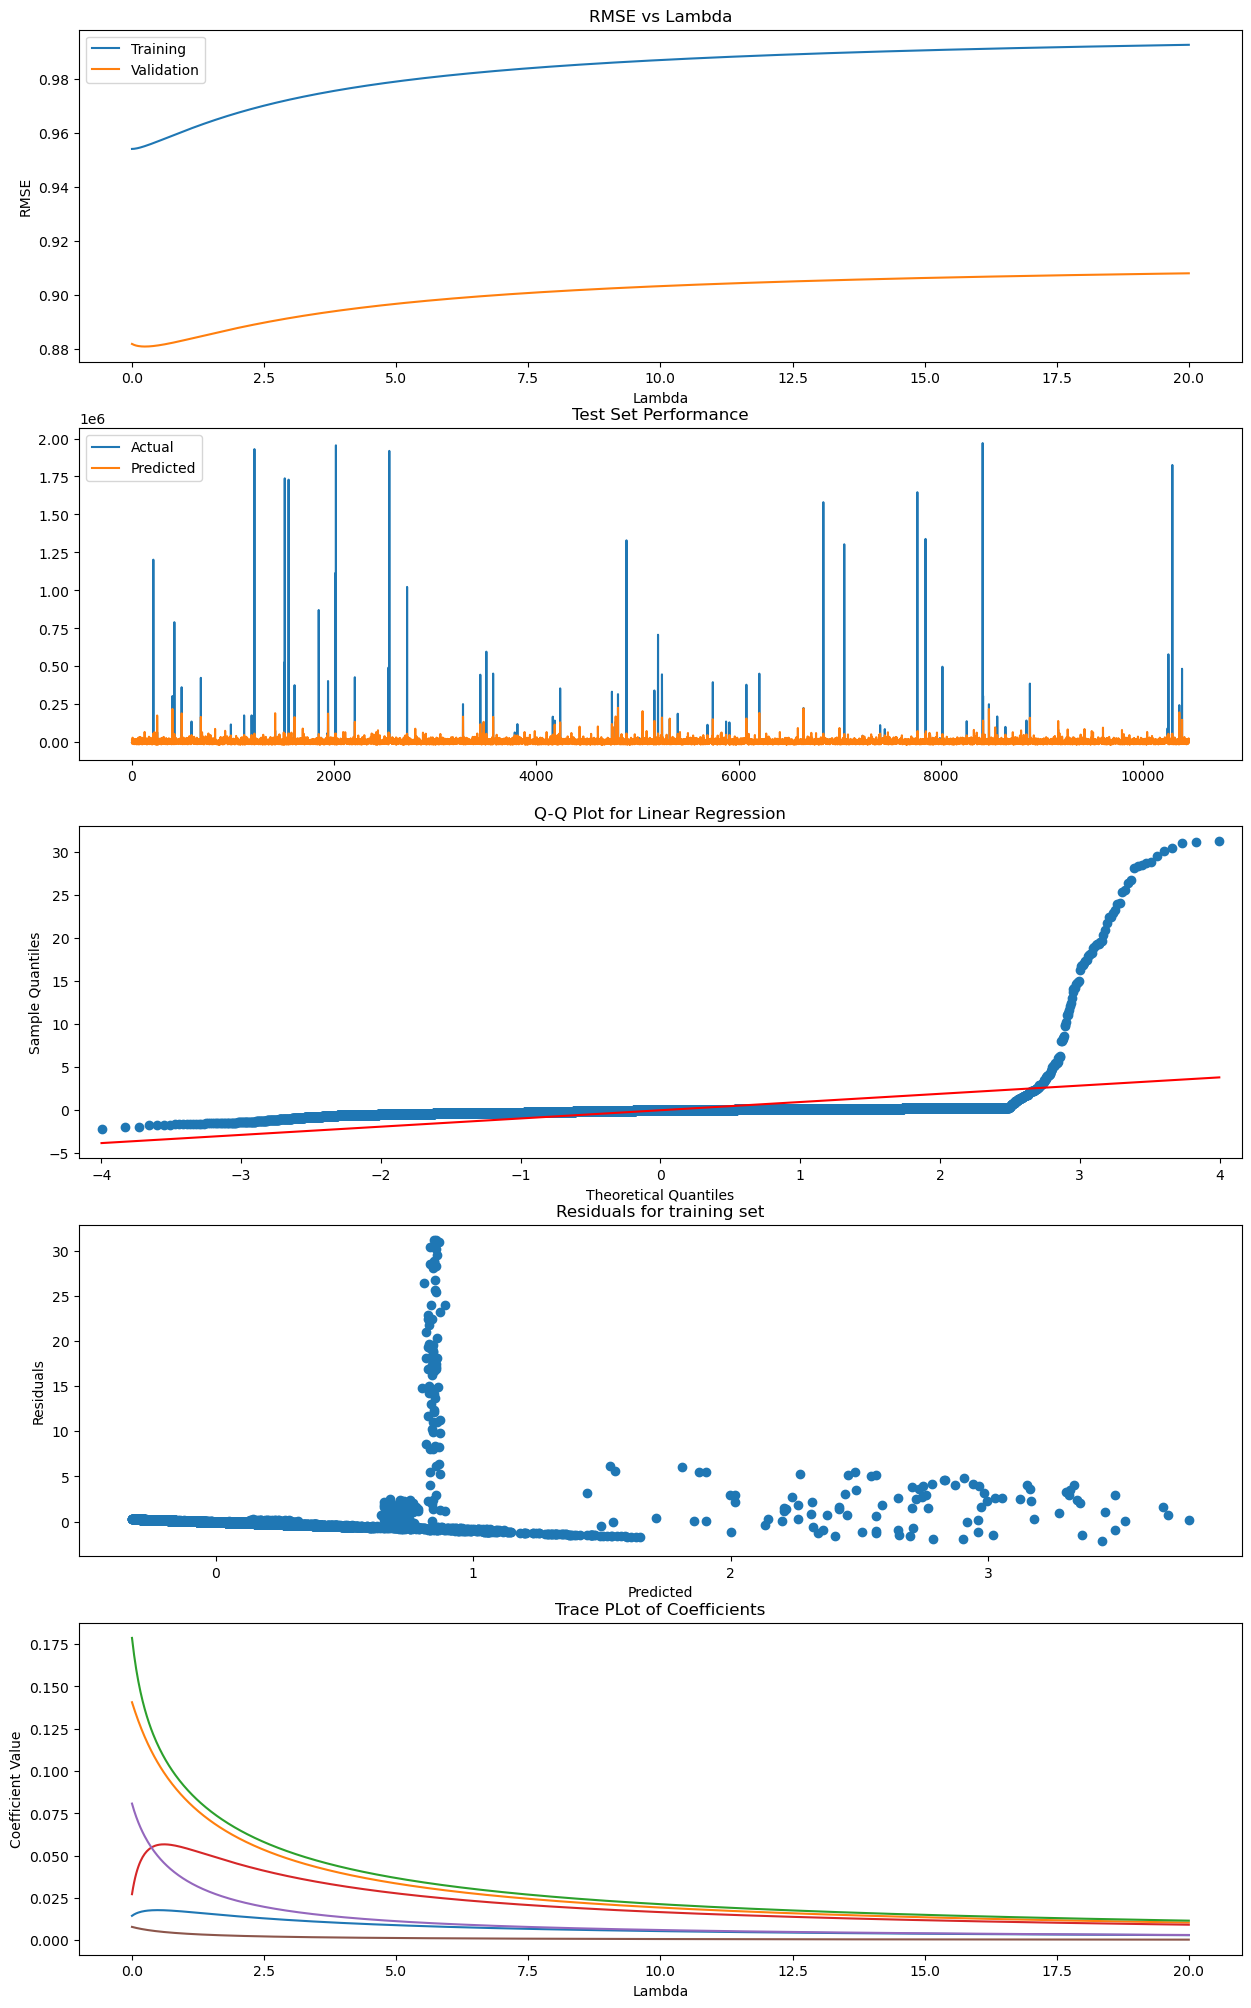

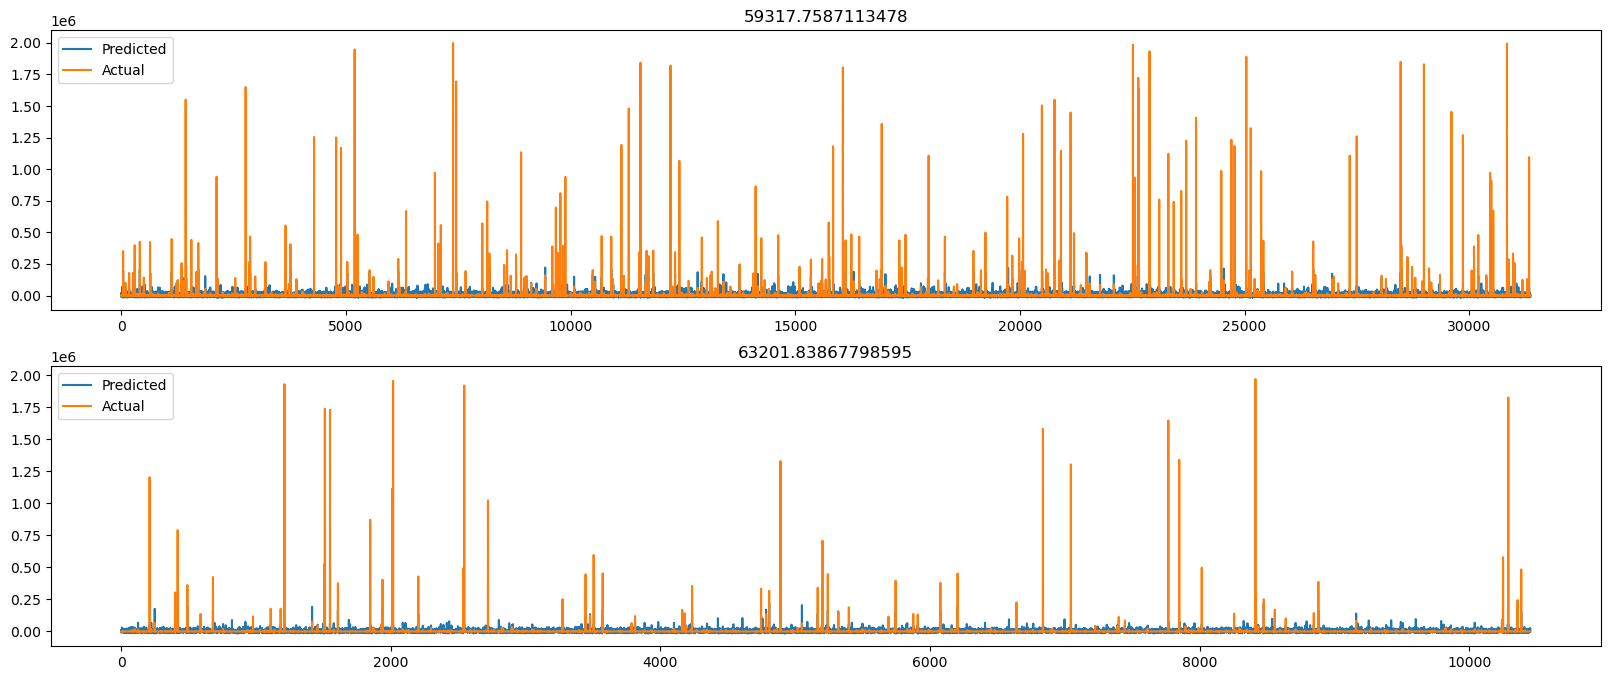

In [13]:
alpha_list = np.linspace(0,20,1000)
ridge_model, ridge_rmse_test, ridge_rmse_train = evaluate_regularisation(X_train_std, Y_train_std, X_val_std, Y_val_std, X_test_std, Y_test_std,
                        mu_train_y, sigma_train_y, alpha_list, 0)

Best values on Validation Data set
Best R Squared = 0.08191194317271477
Best Adjusted = 0.08173623253982909
Best RMSE (train) = 3695697846.52434
Best RMSE (val) = 3403363493.790284
Best RMSE (test) = 3933709481.8627644
Best Alpha = 0.02002002002002002
Best coefficients on the normalised model
Best slope = [[ 9.04099387e-01]
 [ 4.58341509e+03]
 [ 1.80243465e+04]
 [ 4.53503820e+03]
 [ 3.45941988e+01]
 [-8.06378794e+02]]


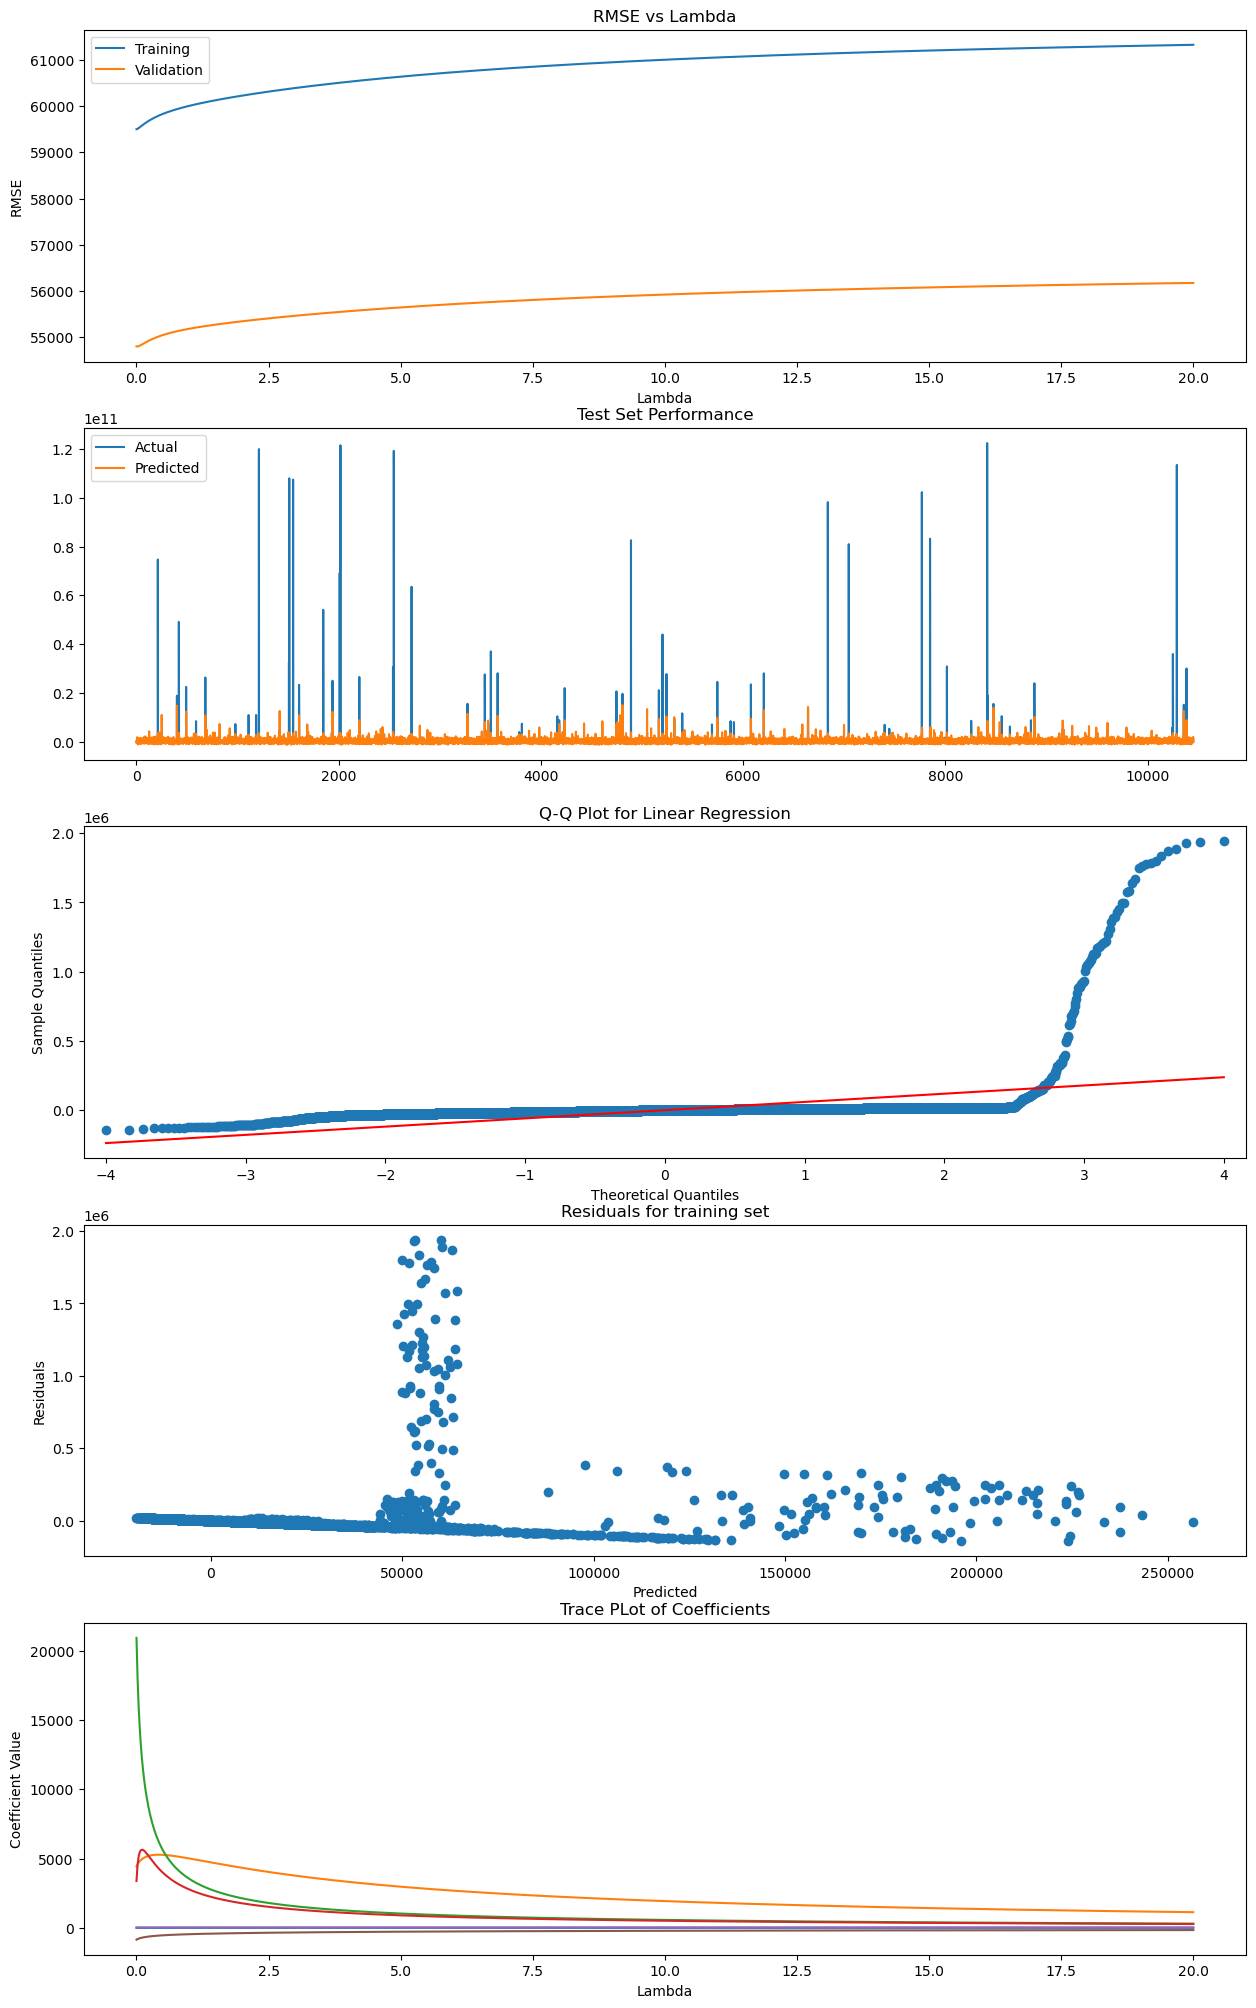

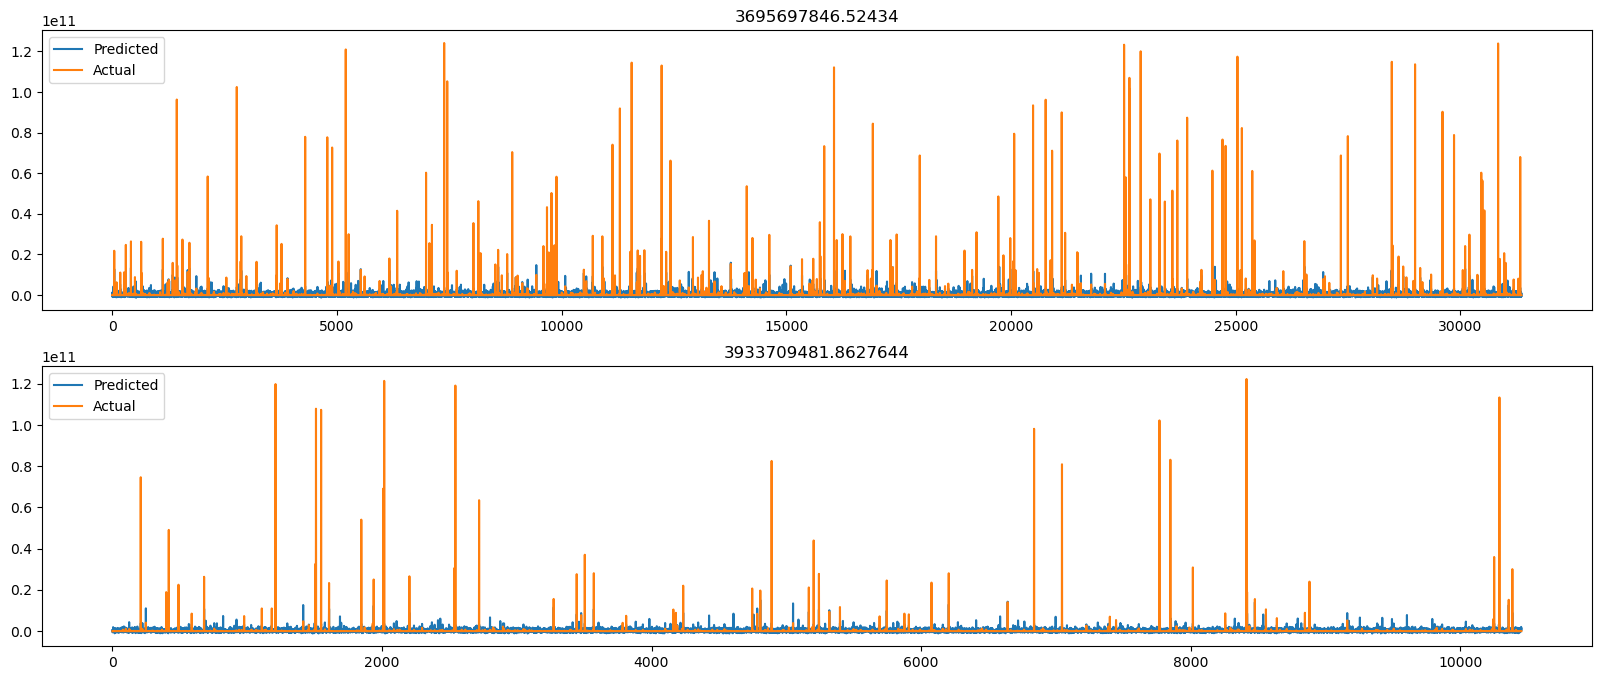

In [14]:
alpha_list = np.linspace(0,20,1000)
ridge_model, ridge_rmse_test, ridge_rmse_train = evaluate_regularisation(X_train, Y_train, X_val, Y_val, X_test, Y_test,
                        mu_train_y, sigma_train_y, alpha_list, 0)